# spaceNNtime development following TF NN example

In this notebook I'll develope spaceNNtime script following first a regression neural network tutorial provided by TensorFlow (https://www.tensorflow.org/tutorials/keras/regression).

## Contents

0. [ Packages ](#Pack)
1. [ TF regression NN example ](#TFNN)
    - 1.1. [ Loading data ](#Load)
    - 1.2. [ Cleaning data ](#Clea)
    - 1.3. [ Divide data into training and testing sets ](#Divi)
    - 1.4. [ Remove labels from dataset ](#Remo)
    - 1.5. [ Normalization ](#Norm)
    - 1.6. [ Linear Regression ](#Line)
    - 1.7. [ Multiple Linear Regression ](#Mult)
    - 1.8. [ DNN ](#DNN)
2. [ spaceNNtime ](#sNNt)


<a name="Pack"></a>
### 0. Packages

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

In [2]:
%load_ext rpy2.ipython

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.2


In [4]:
tf.config.list_physical_devices()

2022-09-22 09:07:04.239477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moicoll/libcurl/lib:/home/moicoll/libcurl/lib:
2022-09-22 09:07:04.239547: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 09:07:04.239584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s21n82): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4419352626246981492
]


2022-09-22 09:07:04.545639: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
%%R

library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


<a name="TFNN"></a>
### 1. TF regression NN example

<a name="Load"></a>
#### 1.1. Load data

In [7]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv("auto-mpg.data", names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


<a name="Clea"></a>
#### 1.2. Clean data

Remove `na`s from the dataset

In [8]:
print("Dataset")
print("-------")
print(dataset.isna().sum())
dataset = dataset.dropna()
print()
print("Clean dataset")
print("-------------")
print(dataset.isna().sum())

Dataset
-------
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Clean dataset
-------------
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


Transform categorical to numerical by first each category transformed to a number and then encoded to a one-hot endoe values with `pd.get_dummies()`

In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset

/scratch/6899867/ipykernel_29593/1867514152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


<a name="Divi"></a>
#### 1.3. Divide data into training and testing sets


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(dataset.shape, train_dataset.shape, test_dataset.shape)

(392, 10) (314, 10) (78, 10)


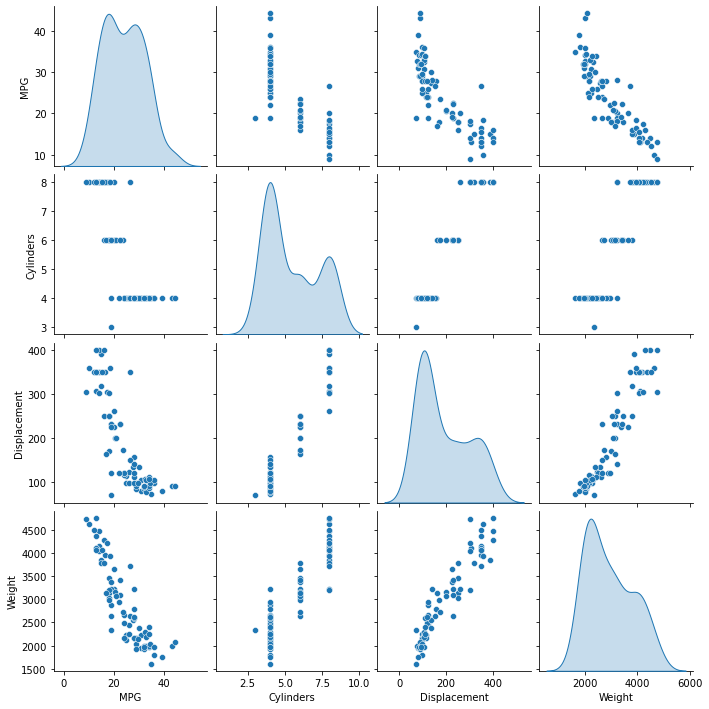

In [11]:
# I don't visualize the training dataset because the notebook dies out
sns.pairplot(test_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


<a name="Remo"></a>
#### 1.4. Remove labels from dataset

In [13]:
print(dataset.shape, train_dataset.shape, test_dataset.shape)

(392, 10) (314, 10) (78, 10)


In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [15]:
print(dataset.shape, train_dataset.shape, test_dataset.shape, train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(392, 10) (314, 10) (78, 10) (314, 9) (78, 9) (314,) (78,)


<a name="Norm"></a>
#### 1.5. Normalization

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)
pd.DataFrame({"mean" : normalizer.mean.numpy().reshape(-1),
              "std"  : np.sqrt(normalizer.variance).reshape(-1)})

2022-09-22 09:07:18.650021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


,mean,std
0,5.477707,1.697079
1,195.318497,104.165314
2,104.869446,38.035500
3,2990.251709,842.553711
4,15.559236,2.784785
5,75.898094,3.669785
6,0.178344,0.382802
7,0.197452,0.398076
8,0.624204,0.484328


In [18]:
pd.DataFrame(normalizer(train_features).numpy())

,0,1,2,3,4,5,6,7,8
0,-0.870736,-1.011071,-0.785304,-1.026940,-0.380365,-0.517222,-0.465891,-0.496016,0.775913
1,-0.870736,-0.531064,-0.443518,-0.118986,0.625098,0.845255,-0.465891,-0.496016,0.775913
2,1.486256,1.484962,1.449450,1.739650,-0.739460,-1.062213,-0.465891,-0.496016,0.775913
3,-0.870736,-0.867069,-1.100799,-1.026940,-0.308547,1.662742,-0.465891,-0.496016,0.775913
4,-0.870736,-0.943870,-0.995634,-1.003202,0.876464,1.117751,-0.465891,2.016065,-1.288805
...,...,...,...,...,...,...,...,...,...
309,0.307760,0.044943,-0.522392,-0.000299,0.948283,0.845255,-0.465891,-0.496016,0.775913
310,1.486256,1.964968,1.975275,1.459549,-1.601285,0.300264,-0.465891,-0.496016,0.775913
311,-0.870736,-0.838268,-0.312062,-0.711233,-0.021271,-0.517222,-0.465891,2.016065,-1.288805
312,-0.870736,-1.078272,-1.153382,-1.171737,1.235559,-0.517222,-0.465891,2.016065,-1.288805


In [19]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


<AxesSubplot:ylabel='Frequency'>

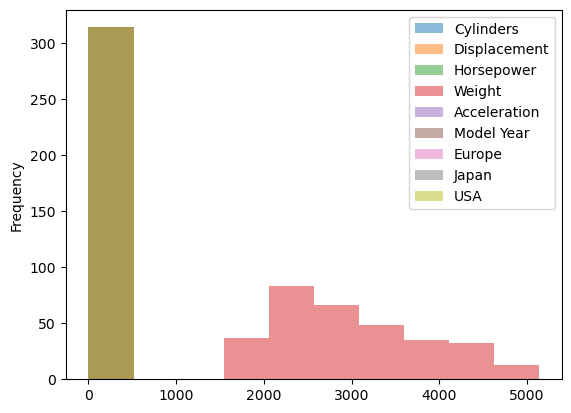

In [20]:
train_features.plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

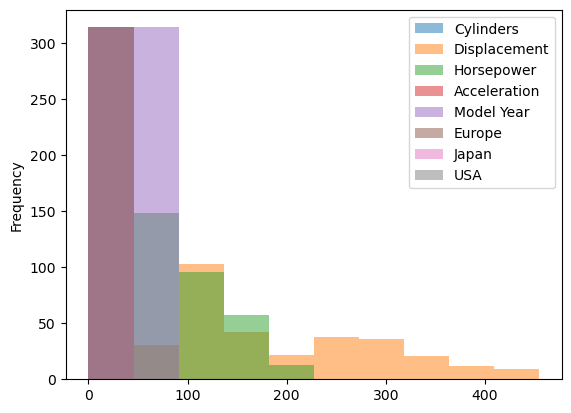

In [21]:
train_features.drop("Weight", axis = 1).plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

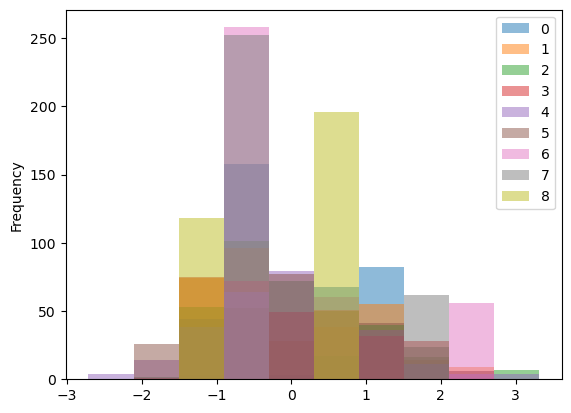

In [22]:
pd.DataFrame(normalizer(train_features).numpy()).plot.hist(alpha=0.5)

<a name="Line"></a>
#### 1.6. Linear Regression

In [23]:
horsepower = np.array(train_features['Horsepower'])
print(horsepower.shape)
horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1, ], axis=None)
horsepower_normalizer.adapt(horsepower)
print(horsepower_normalizer.mean.numpy()[0], np.sqrt(horsepower_normalizer.variance)[0])

(314,)
104.869446 38.0355


In [24]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [25]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [26]:
history = horsepower_model.fit(train_features['Horsepower'],
                     train_labels, 
                     epochs=100,
                     verbose = 0,
                     validation_split = 0.2)

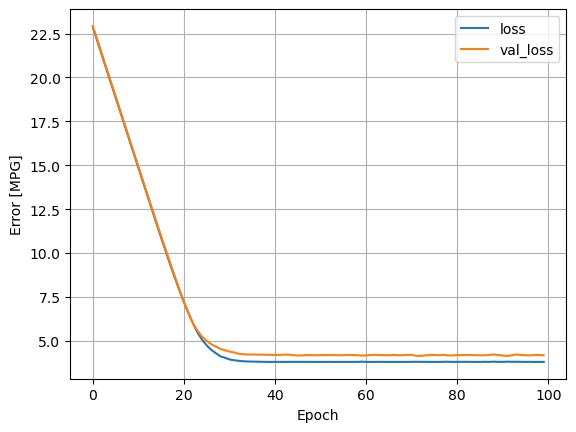

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [28]:
test_results= {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)


In [29]:
test_labels

9      15.0
25     10.0
28      9.0
31     25.0
33     19.0
       ... 
369    34.0
375    36.0
382    34.0
384    32.0
396    28.0
Name: MPG, Length: 78, dtype: float64

In [30]:
x = tf.linspace(0.0, 250, 10)
y = horsepower_model.predict(x)

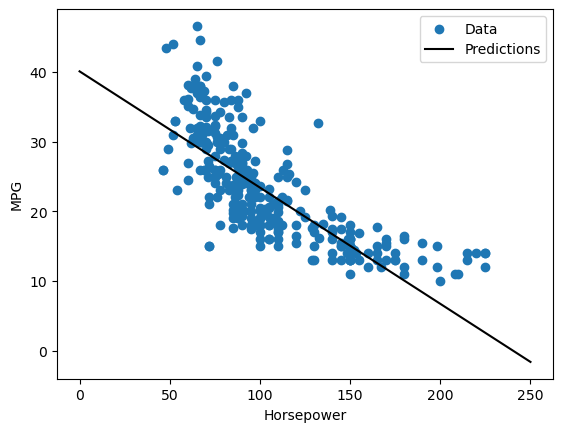

In [31]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()
plot_horsepower(x, y)

In [32]:
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


<a name="Mult"></a>
#### 1.7. Multiple Linear Regression

(314, 9)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________
None
{'horsepower_model': 3.644362688064575, 'MLR_model': 2.458172559738159}


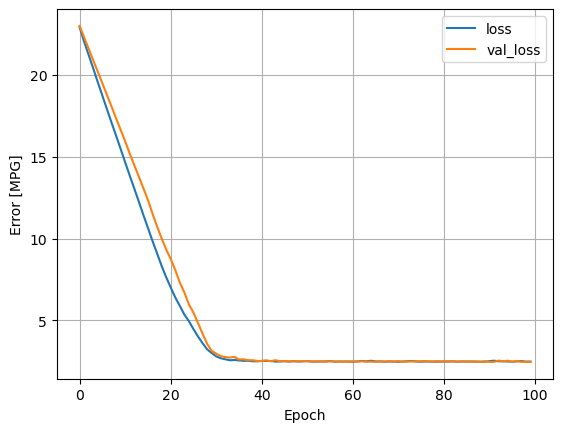

In [33]:
print(train_features.shape)
MLR_normalizer = tf.keras.layers.Normalization(input_shape=[train_features.shape[1], ], axis= -1)
MLR_normalizer.adapt(train_features)

MLR_model = tf.keras.Sequential([
    MLR_normalizer,
    layers.Dense(units=1)
])

print(MLR_model.summary())

MLR_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = MLR_model.fit(train_features,
                        train_labels, 
                        epochs=100,
                        verbose = 0,
                        validation_split = 0.2)

test_results['MLR_model'] = MLR_model.evaluate(test_features,
                                               test_labels, 
                                               verbose=0)

print(test_results)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(history)

In [34]:
MLR_model.predict(test_features[:10])

array([[13.586946],
       [ 7.810258],
       [ 6.700815],
       [26.716194],
       [21.431393],
       [11.327893],
       [12.743339],
       [10.229613],
       [19.354826],
       [28.80186 ]], dtype=float32)

In [35]:
test_labels[:10]

9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
39    14.0
40    14.0
43    13.0
48    18.0
54    35.0
Name: MPG, dtype: float64

<a name="DNN"></a>
#### 1.8. DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________
None
{'horsepower_model': 3.644362688064575, 'MLR_model': 2.458172559738159, 'DNN_model': 1.6650604009628296}


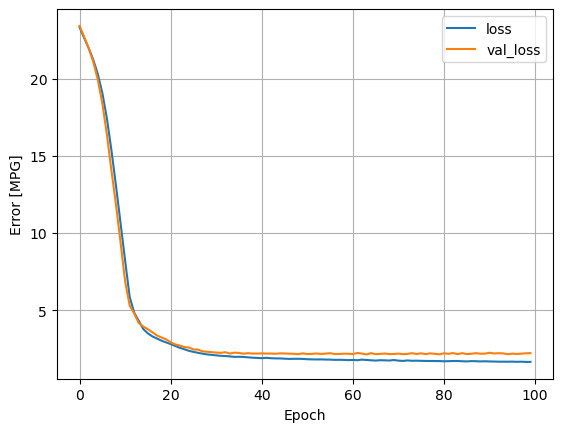

In [36]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

DNN_normalizer = tf.keras.layers.Normalization(input_shape=[train_features.shape[1], ], axis= -1)
DNN_normalizer.adapt(train_features)
DNN_model = build_and_compile_model(DNN_normalizer)

print(DNN_model.summary())

history = DNN_model.fit(train_features,
                        train_labels, 
                        epochs           = 100,
                        verbose          = 0,
                        validation_split = 0.2)

test_results['DNN_model'] = DNN_model.evaluate(test_features,
                                               test_labels, 
                                               verbose=0)

print(test_results)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(history)
#dnn_model.save('DNN_model')

<a name="DNN"></a>
##### 1.8.1. DNN prediction intervals

Here I try to investigate different methods to create prediction intervals for the predictions that the NN made.

Bibliography:

- How to generate neural network confidence intervals with Keras

https://medium.com/hal24k-techblog/how-to-generate-neural-network-confidence-intervals-with-keras-e4c0b78ebbdf

Blog that shows how by making several predictions with dropout, we can achieve a distribution of predictions with training the model only once. I'm not 100% convinced about the technique because uncertanty can be divided into three main factors : i) Variance of the method which corresponds to the fact that the medhod trained is not necessary the maximum optima but just a local optima thus there might be other models that perform similarly well in the likelihood function defined. ii) Sampling variance since the sample we train the model on is not infinite and there might be some uncertainty asociated to it. iii) Error of the prediction. This is basically the concept that even though we found the optimum, there might be unexplained variation by our model which contributes to the uncertainty. 

In my opinion this method might be good at capturing ii and iii, but not i. 

The very good point about this blog is the fact that they explain how to make a sanity check to see if you method works: qq plot with quantile distribution vs predictions within the quintile. 

I could not use the code provided in which they force the prediction step in Keras to use dropout. Instead, I implemented my own way to just take the train weights and with a probability p, shut down rows of weights (w = 0) and with that model, do a prediction. 

- Estimating Uncertainty in Machine Learning Models - Part 2

https://medium.com/comet-ml/estimating-uncertainty-in-machine-learning-models-part-2-8711c832cc15

Blog that gave me the idea that I can correlate CI with error between prediction and real values. He also takes a shot to the bootstrap prediction interval approach.

This has another way to perform dropout on predictions, however, it is different from what I do in my code, so I went along with my custome made code. 

- Estimating Uncertainty in Machine Learning Models — Part 3

https://medium.com/cometheartbeat/estimating-uncertainty-in-machine-learning-models-part-3-1b92c344e9c4

This blog is the same guy as before, but explains the method of constructing another NN in order to estimate prediction intervals based on the assumption that uncertanty is normally distributed.

- Prediction Intervals for Deep Learning Neural Networks

https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/

blog that assumes that since NN start with random Networks, they will end up in different points of the likelihood space making every prediction independent.


- Comprehensive Review of Neural Network-Based Prediction Intervals and New Advances

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5966350

Review

- Estimation of Prediction Intervals in Neural Network-based Regression Models

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8750774&tag=1

Review

- Estimating Neural Network’s Performance with Bootstrap: a Tutorial

file:///Users/au552345/Desktop/preprints202101.0431.v1.pdf

Paper showing that you can do bootstrap on the validation set such that you get an estimate on the loss function, but not on the prediction of the samples

- Uncertainty Quantification in CNN Through the Bootstrap of Convex Neural Networks

file:///Users/au552345/Desktop/17434-Article%20Text-20928-1-2-20210518.pdf

Similar than the one before


In [38]:
%%time
#0.1, 0.2, 0.3, 0.4,
quantiles    = np.arange(0, 1, 0.01)
dropoutspred = np.array([0, 0.025, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])
dropoutspred = np.arange(0.06, 0.07, 0.0025)
#dropoutspred = np.array([0.01, 0.02, 0.0225, 0.025, 0.05, 0.075])
sampling_size = 100
within_list    = []
dropout_list   = []
quantiles_list = []

model_copy= keras.models.clone_model(DNN_model)
model_copy.set_weights(DNN_model.get_weights())
for dropoutpred in dropoutspred:
    print("Dropout {}".format(dropoutpred))
    prediction_intervals = []
    for j in range(sampling_size):
        print("{:3.2f} %".format((j/sampling_size)*100), end = "\r")
        for i, l in enumerate(DNN_model.layers):
            if i < 3 and i > 0 and "dense" in l.name:
                #print(i, l.name, l.get_weights()[0].shape)
                w = l.get_weights()[0]
                dropoutnodes = np.random.binomial(1, dropoutpred, size = w.shape[0]).astype(bool)
                w[dropoutnodes, :] = np.zeros((w.shape[1],))
                model_copy.layers[i].set_weights([w, DNN_model.layers[i].get_weights()[1]])

        prediction_intervals.append(model_copy.predict(test_features))

    print("{:3.2f} %".format(((j+1)/sampling_size)*100))
    prediction_intervals = np.array(prediction_intervals)
    #print(((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < test_labels.to_numpy().reshape(-1, 1)) * (test_labels.to_numpy().reshape(-1, 1) < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/test_features.shape[0])
    within_list.append((((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < test_labels.to_numpy().reshape(-1, 1)) * (test_labels.to_numpy().reshape(-1, 1) < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/test_features.shape[0]).reshape(-1))
    #quantiles_corrected = 
    #within_list.append(((norm.ppf((0.5-quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0)).T < test_labels.to_numpy()) * 
    #                    (norm.ppf((0.5+quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0)).T > test_labels.to_numpy())).sum(axis = 1)/test_features.shape[0])
    quantiles_list.append(quantiles)
    dropout_list.append([dropoutpred]*quantiles.shape[0])
       

Dropout 0.06
100.00 %
Dropout 0.0625
100.00 %
Dropout 0.065
100.00 %
Dropout 0.0675
100.00 %
Dropout 0.07
100.00 %
CPU times: user 13.4 s, sys: 167 ms, total: 13.5 s
Wall time: 13.8 s


In [39]:
df = pd.DataFrame({"dro" : np.array(dropout_list).reshape(-1),
                   "qua" : np.array(quantiles_list).reshape(-1),
                   "wit" : np.array(within_list).reshape(-1)})

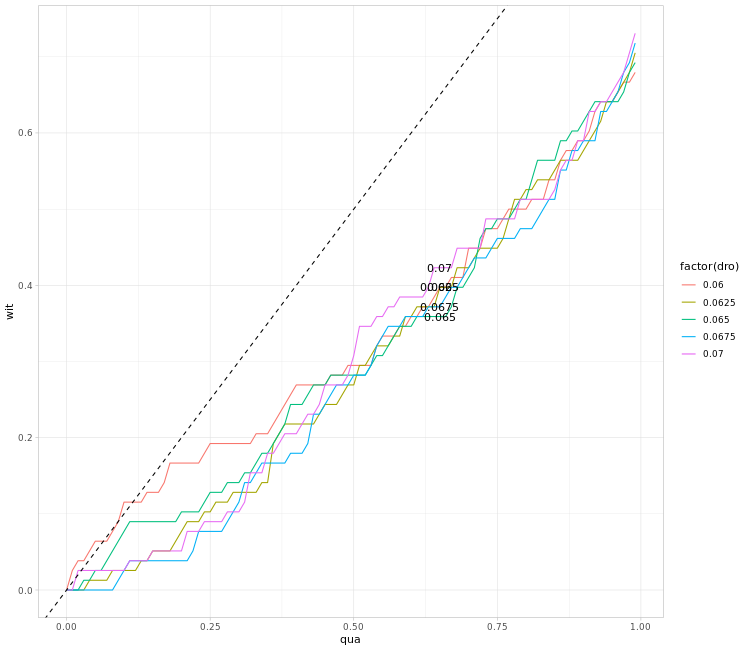

In [40]:
%%R -i df -w 750 -h 650

df %>%
    ggplot() +
    geom_line(aes(x = qua, y = wit, color = factor(dro))) +
    geom_text(data = . %>% filter(qua == 0.65), aes(x = qua, y = wit, label = dro)) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    theme_light()


In [45]:
%%time
#0.1, 0.2, 0.3, 0.4,
quantiles    = np.arange(0, 1, 0.01)
dropoutspred = np.array([0, 0.025, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])
dropoutspred = np.arange(0.06, 0.07, 0.0025)
#dropoutspred = np.array([0.01, 0.02, 0.0225, 0.025, 0.05, 0.075])
sampling_size = 100
within_list    = []
dropout_list   = []
quantiles_list = []

model_copy= keras.models.clone_model(DNN_model)
model_copy.set_weights(DNN_model.get_weights())
for dropoutpred in dropoutspred:
    print("Dropout {}".format(dropoutpred))
    prediction_intervals = []
    for j in range(sampling_size):
        print("{:3.2f} %".format((j/sampling_size)*100), end = "\r")
        for i, l in enumerate(DNN_model.layers):
            if i < 3 and i > 0 and "dense" in l.name:
                #print(i, l.name, l.get_weights()[0].shape)
                w = l.get_weights()[0]
                dropoutnodes = np.random.binomial(1, dropoutpred, size = w.shape[0]).astype(bool)
                w[dropoutnodes, :] = np.zeros((w.shape[1],))
                model_copy.layers[i].set_weights([w, DNN_model.layers[i].get_weights()[1]])

        prediction_intervals.append(model_copy.predict(test_features))

    print("{:3.2f} %".format(((j+1)/sampling_size)*100))
    prediction_intervals = np.array(prediction_intervals)
    #print(((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < test_labels.to_numpy().reshape(-1, 1)) * (test_labels.to_numpy().reshape(-1, 1) < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/test_features.shape[0])
    #within_list.append((((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < test_labels.to_numpy().reshape(-1, 1)) * (test_labels.to_numpy().reshape(-1, 1) < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/test_features.shape[0]).reshape(-1))
    within_list.append(((norm.ppf((0.5-quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0)).T < test_labels.to_numpy()) * 
                        (norm.ppf((0.5+quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0)).T > test_labels.to_numpy())).sum(axis = 1)/test_features.shape[0])
    quantiles_list.append(quantiles)
    dropout_list.append([dropoutpred]*quantiles.shape[0])
       
    

Dropout 0.06
100.00 %
Dropout 0.0625
100.00 %
Dropout 0.065
100.00 %
Dropout 0.0675
100.00 %
Dropout 0.07
100.00 %
CPU times: user 13.3 s, sys: 142 ms, total: 13.4 s
Wall time: 13.7 s


In [46]:
df = pd.DataFrame({"dro" : np.array(dropout_list).reshape(-1),
                   "qua" : np.array(quantiles_list).reshape(-1),
                   "wit" : np.array(within_list).reshape(-1)})

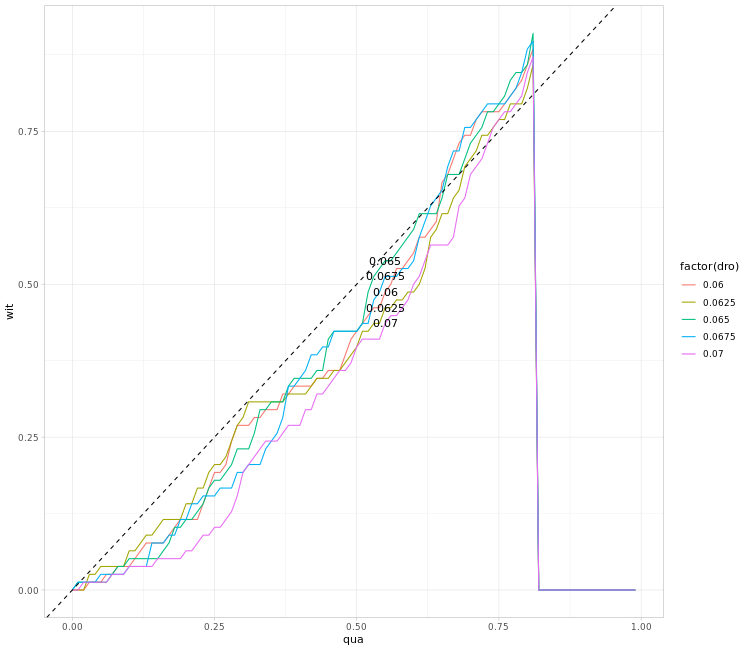

In [47]:
%%R -i df -w 750 -h 650

df %>%
    ggplot() +
    geom_line(aes(x = qua, y = wit, color = factor(dro))) +
    geom_text(data = . %>% filter(qua == 0.55), aes(x = qua, y = wit, label = dro)) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    theme_light()


<a name="sNNt"></a>
### 2. spaceNNtime

In [102]:
import simGL
import sklearn
#import msprime
import tskit
import sys
sys.path.insert(1, '../../scripts')
import spaceNNtime_templates
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

In [103]:
sim, exp, nam, met, snp, pre, typ, cov, err, nod = ["europe", "5", "gold", "5", 1.0, "sNNt", "gt", 0, 0, 64]
ts            = tskit.load("/home/moicoll/spaceNNtime/data/{sim}/tree.trees".format(sim = sim))
metadata      = pd.read_csv("/home/moicoll/spaceNNtime/data/{sim}/metadata/{met}.txt".format(sim = sim, met = met), delimiter = "\t")
input         = spaceNNtime_templates.get_input(ts, metadata, snp, typ, cov, err)
output        = spaceNNtime_templates.get_output(pre, metadata)
tra_val_tes   = spaceNNtime_templates.get_tra_val_tes(metadata["ind_id"].to_numpy(), file = "/home/moicoll/spaceNNtime/sandbox/{sim}/{met}/tra_val_tes_{met}.json".format(sim = sim, met = met))

In [104]:
n = metadata.shape[0]
g = 5

kf = KFold(n_splits=int(np.ceil(n/g)), shuffle = True, random_state = 1234)
for i, train_test_index in enumerate(kf.split(np.arange(n))):
    train_index, test_index = train_test_index
    print(i, "TRAIN:", train_index, "TEST:", test_index)
    if i > 4:
        break

0 TRAIN: [   0    1    2 ... 1497 1498 1499] TEST: [ 78 351 366 564 755]
1 TRAIN: [   0    1    2 ... 1497 1498 1499] TEST: [ 141  362  842  903 1169]
2 TRAIN: [   0    1    2 ... 1497 1498 1499] TEST: [ 875  892  915 1041 1173]
3 TRAIN: [   0    1    2 ... 1497 1498 1499] TEST: [ 622  851 1040 1354 1424]
4 TRAIN: [   0    1    2 ... 1497 1498 1499] TEST: [  34  235  681 1151 1270]
5 TRAIN: [   0    1    2 ... 1497 1498 1499] TEST: [ 866 1054 1194 1305 1347]


In [105]:
train_features = input.T[tra_val_tes["0"]["tra"], :]
train_labels   = output[tra_val_tes["0"]["tra"], :]
test_features  = input.T[tra_val_tes["0"]["tes"], :]
test_labels    = output[tra_val_tes["0"]["tes"], :]
val_features   = input.T[tra_val_tes["0"]["val"], :]
val_labels     = output[tra_val_tes["0"]["val"], :]

In [106]:
train_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [107]:
def tf_atan2(y, x):

    angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), np.nan * tf.zeros_like(x), angle)
    return angle

def tf_haversine(latlon1, latlon2):

    lat1 = latlon1[:, 0]
    lon1 = latlon1[:, 1]
    lat2 = latlon2[:, 0]
    lon2 = latlon2[:, 1]

    REarth = 6371
    lat = tf.abs(lat1 - lat2) * np.pi / 180
    lon = tf.abs(lon1 - lon2) * np.pi / 180
    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180
    a = tf.sin(lat / 2) * tf.sin(lat / 2) + tf.cos(lat1) * tf.cos(lat2) * tf.sin(lon / 2) * tf.sin(lon / 2)
    d = 2 * tf_atan2(tf.sqrt(a), tf.sqrt(1 - a))
    return REarth * d

In [108]:
def haversine_distance_time_difference(w_space = 1, w_time = 1, w_sample = np.array(1)):
    '''
    https://medium.com/@Bloomore/how-to-write-a-custom-loss-function-with-additional-arguments-in-keras-5f193929f7a0
    '''
    def loss(y_true, y_pred):
        err_space = tf_haversine(y_true[:, 0:2], y_pred[:, 0:2])*w_space
        err_time  = mean_squared_error(tf.reshape(y_true[:, 2], (-1, 1)), tf.reshape(y_pred[:, 2], (-1, 1)))*w_time
        return K.mean(tf.transpose(tf.reshape(K.concatenate((err_space, err_time)), (2, -1)))*w_sample.reshape(-1, 1), axis=-1)
    return loss

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis = -1))

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis = -1)

In [109]:
def dense_batchnorm_activation(model, l, n, dropout_prop, input_shape = None):
    for _ in range(l):
        if input_shape == None:
            model.add(tf.keras.layers.Dense(n))
        else:
            model.add(tf.keras.layers.Dense(n, input_shape = input_shape))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('elu'))
        model.add(tf.keras.layers.Dropout(dropout_prop))
        
def spaceNNtime(input_shape, output_shape, norm = None, dropout_prop = 0.25, l = 10, n = 256, loss_function = "edl", w_time = 1, w_space = 1, w_sample = np.array(1)):
    model = tf.keras.Sequential()                                             #Start a fully connected neural network
    model.add(tf.keras.Input(shape=input_shape))

#    if isinstance(norm, tf.keras.layers.Normalization):                       #If the input is normalized, 
#        model.add(norm)                                                              #add a normalization layer
#        dense_batchnorm_activation(model, l = 1, n = n, dropout_prop = dropout_prop) #and start the first fully connected layer
#    else:                                                                     #Otherwise
#        dense_batchnorm_activation(model, l = 1, n = n, dropout_prop = dropout_prop, input_shape = input_shape) #Start manually the first layer indicating the input shape
    dense_batchnorm_activation(model, l = int(np.floor(l/2)), n = n, dropout_prop = dropout_prop) # Add half of the desired layers
    #model.add(tf.keras.layers.Dropout(dropout_prop))                           # Add a drop out layer
    dense_batchnorm_activation(model, l = int(np.ceil(l/2)), n = n,  dropout_prop = dropout_prop)    # Add the rest of the desired layers
    [model.add(tf.keras.layers.Dense(output_shape)) for _ in range(2)]         # Add two extra layers for the output
    
    if loss_function == "edl":                                                 # Compile the model deciding on the loss function and the optimizer
        model.compile(optimizer="Adam", loss=euclidean_distance_loss)
    elif loss_function == "hdtd":
        model.compile(optimizer="Adam", loss=haversine_distance_time_difference(w_time = w_time, w_space = w_space, w_sample = w_sample))
    elif loss_function == "hd":
        model.compile(optimizer="Adam", loss=tf_haversine)
    elif loss_function == "mse":
        model.compile(optimizer="Adam", loss=mean_squared_error)
    return model

def train_spaceNNtime(model, tra_fea, tra_lab, val_fea, val_lab, callbacks):
    history = model.fit(x               = tra_fea, 
                        y               = tra_lab,
                        epochs          = 5000,
                        batch_size      =   32,
                        shuffle         = True,
                        verbose         = False,
                        validation_data = (val_fea, val_lab),
                        callbacks       = callbacks)
    return history

def plot_loss(history, fig_path = None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    if fig_path:
        fig  = plt.figure()
    plt.axvline(x = int(hist[np.min(hist["val_loss"]) == hist["val_loss"]]["epoch"]), c = "red", alpha = 0.5, linestyle = "dashed", label='Early Stop')
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((0, 1e7))
    plt.legend()
    plt.grid(True)
    if fig_path:
        fig.savefig(fig_path)
        plt.close()

In [110]:
%%time

tf.random.set_seed(1234)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                           min_delta=0,
                                           patience=100,
                                           verbose=1)
    
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.5,
                                              patience=20)


model = spaceNNtime(input_shape   = [train_features.shape[1], ], 
                    output_shape  = train_labels.shape[1], 
                    norm          = None, 
                    dropout_prop  = 0.5, 
                    l             = 10, 
                    n             = 64, 
                    loss_function = "hdtd", 
                    w_time        = 1, 
                    w_space       = 1000, 
                    w_sample      = np.array(1))

model.summary()

#model.load_weights("/home/moicoll/spaceNNtime/sandbox/europe/7/models/group0_weights.hdf5")

history = train_spaceNNtime(model     = model, 
                            tra_fea   = train_features, 
                            tra_lab   = train_labels, 
                            val_fea   = val_features, 
                            val_lab   = val_labels, 
                            callbacks = [earlystop, reducelr])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                86080     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)               

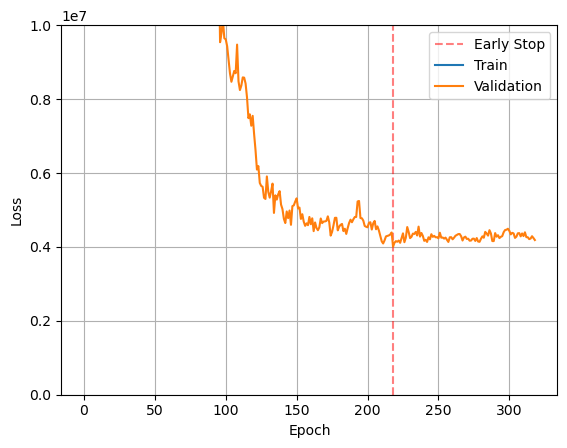

In [111]:
plot_loss(history)

In [112]:
model_copy= keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())

In [113]:
model.predict(test_features)

array([[4.1997372e+01, 2.0703993e+01, 3.3126768e+03],
       [4.1024090e+01, 2.2615696e+01, 5.7192773e+03],
       [3.9254417e+01, 5.6936050e+01, 4.2285461e+04]], dtype=float32)

In [114]:
model_copy.predict(test_features)

array([[4.1997372e+01, 2.0703993e+01, 3.3126768e+03],
       [4.1024090e+01, 2.2615696e+01, 5.7192773e+03],
       [3.9254417e+01, 5.6936050e+01, 4.2285461e+04]], dtype=float32)

In [115]:
test_labels

array([[5.75975769e+01, 3.58414075e+01, 5.46800000e+03],
       [4.76666245e+01, 3.39797249e+00, 9.25000000e+03],
       [2.99269557e+01, 5.12378384e+01, 4.38070000e+04]])

In [ ]:
%%time
#0.1, 0.2, 0.3, 0.4,
quantiles    = np.arange(0, 1, 0.05)
dropoutspred = np.array([0, 0.025, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])
dropoutspred = np.arange(0.05, 0.07, 0.0025)
#dropoutspred = np.array([0.01, 0.02, 0.0225, 0.025, 0.05, 0.075])
sampling_size = 50
within_list    = []
dropout_list   = []
quantiles_list = []

model_copy= keras.models.clone_model(DNN_model)
model_copy.set_weights(DNN_model.get_weights())
for dropoutpred in dropoutspred:
    print("Dropout {}".format(dropoutpred))
    prediction_intervals = []
    for j in range(sampling_size):
        print("{:3.2f} %".format((j/sampling_size)*100), end = "\r")
        for i, l in enumerate(DNN_model.layers):
            if i < 3 and i > 0 and "dense" in l.name:
                #print(i, l.name, l.get_weights()[0].shape)
                w = l.get_weights()[0]
                dropoutnodes = np.random.binomial(1, dropoutpred, size = w.shape[0]).astype(bool)
                w[dropoutnodes, :] = np.zeros((w.shape[1],))
                model_copy.layers[i].set_weights([w, DNN_model.layers[i].get_weights()[1]])

        prediction_intervals.append(model_copy.predict(test_features))

    print("{:3.2f} %".format(((j+1)/sampling_size)*100))
    prediction_intervals = np.array(prediction_intervals)
    #print(((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < test_labels.to_numpy().reshape(-1, 1)) * (test_labels.to_numpy().reshape(-1, 1) < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/test_features.shape[0])
    within_list.append((((np.quantile(prediction_intervals, q = (0.5-quantiles/2)*1.5, axis = 0) < test_labels.to_numpy().reshape(-1, 1)) * (test_labels.to_numpy().reshape(-1, 1) < np.quantile(prediction_intervals, q = (0.5+quantiles/2)*1.5, axis = 0))).sum(axis = 1)/test_features.shape[0]).reshape(-1))
    quantiles_list.append(quantiles)
    dropout_list.append([dropoutpred]*quantiles.shape[0])
       

In [127]:
%%time

quantiles      = np.arange(0, 1, 0.05)
dropoutspred   = np.arange(0.075, 0.125, 0.0025)
#dropoutspred   = np.array([0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.375,  0.5, 0.625, 0.75])
sampling_size  = 50
within_list    = []
dropout_list   = []
quantiles_list = []

model_copy= keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
for dropoutpred in dropoutspred:
    print("Dropout {}".format(dropoutpred))
    prediction_intervals = []
    for j in range(sampling_size):
        print("{:3.2f} %".format((j/sampling_size)*100), end = "\r")
        for i, l in enumerate(model.layers):
            if i < 40 and i > 1 and "dense" in l.name:
                #print(i, l.name, l.get_weights()[0].shape)
                w = l.get_weights()[0]
                dropoutnodes = np.random.binomial(1, dropoutpred, size = w.shape[0]).astype(bool)
                w[dropoutnodes, :] = np.zeros((w.shape[1],))
                model_copy.layers[i].set_weights([w, model.layers[i].get_weights()[1]])

        prediction_intervals.append(model_copy.predict(val_features))

    print("{:3.2f} %".format(((j+1)/sampling_size)*100))
    prediction_intervals = np.array(prediction_intervals)
    #print(((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0])
    within_list.append((((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]))
    quantiles_list.append(quantiles)
    dropout_list.append([dropoutpred]*quantiles.shape[0])

Dropout 0.075
100.00 %
Dropout 0.0775
100.00 %
Dropout 0.08
100.00 %
Dropout 0.0825
100.00 %
Dropout 0.085
100.00 %
Dropout 0.08750000000000001
100.00 %
Dropout 0.09000000000000001
100.00 %
Dropout 0.09250000000000001
100.00 %
Dropout 0.09500000000000001
100.00 %
Dropout 0.09750000000000002
100.00 %
Dropout 0.10000000000000002
100.00 %
Dropout 0.10250000000000002
100.00 %
Dropout 0.10500000000000002
100.00 %
Dropout 0.10750000000000003
100.00 %
Dropout 0.11000000000000003
100.00 %
Dropout 0.11250000000000003
100.00 %
Dropout 0.11500000000000003
100.00 %
Dropout 0.11750000000000003
100.00 %
Dropout 0.12000000000000004
100.00 %
Dropout 0.12250000000000004
100.00 %
CPU times: user 31.6 s, sys: 340 ms, total: 31.9 s
Wall time: 32.7 s


In [128]:
np.array(within_list).shape

(20, 20, 3)

In [129]:
df = pd.DataFrame({"dro" : np.array(dropout_list).reshape(-1),
                   "qua" : np.array(quantiles_list).reshape(-1),
                   "lat" : np.array(within_list)[:, :, 0].reshape(-1),
                   "lon" : np.array(within_list)[:, :, 1].reshape(-1),
                   "tim" : np.array(within_list)[:, :, 2].reshape(-1)})

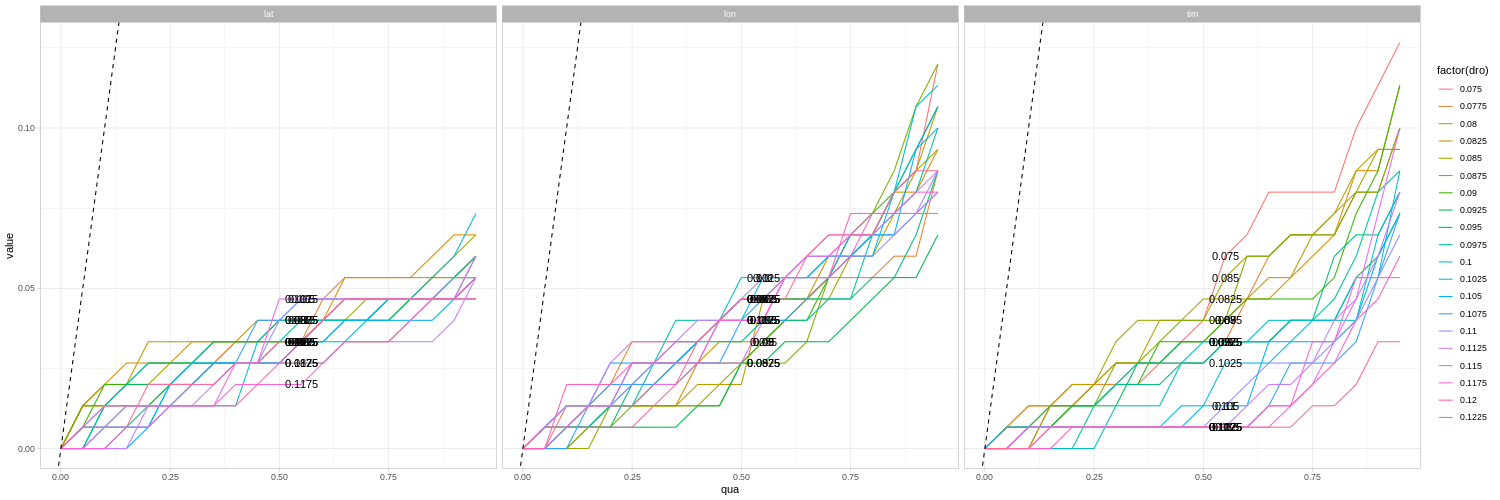

In [130]:
%%R -i df -w 1500 -h 500

df %>%
    gather("stat", "value", c(lat, lon, tim)) %>%
    ggplot() +
    geom_line(aes(x = qua, y = value, color = factor(dro))) +
    geom_text(data = . %>% filter(qua == 0.55), aes(x = qua, y = value, label = dro)) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    theme_light() +
    facet_grid(.~stat)


In [132]:
%%time

quantiles      = np.arange(0, 1, 0.05)
dropoutspred   = np.arange(0.075, 0.125, 0.0025)
#dropoutspred   = np.array([0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.375,  0.5, 0.625, 0.75])
sampling_size  = 50
within_list    = []
dropout_list   = []
quantiles_list = []

model_copy= keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
for dropoutpred in dropoutspred:
    print("Dropout {}".format(dropoutpred))
    prediction_intervals = []
    for j in range(sampling_size):
        print("{:3.2f} %".format((j/sampling_size)*100), end = "\r")
        for i, l in enumerate(model.layers):
            if i < 40 and i > 1 and "dense" in l.name:
                #print(i, l.name, l.get_weights()[0].shape)
                w = l.get_weights()[0]
                dropoutnodes = np.random.binomial(1, dropoutpred, size = w.shape[0]).astype(bool)
                w[dropoutnodes, :] = np.zeros((w.shape[1],))
                model_copy.layers[i].set_weights([w, model.layers[i].get_weights()[1]])

        prediction_intervals.append(model_copy.predict(val_features))

    print("{:3.2f} %".format(((j+1)/sampling_size)*100))
    prediction_intervals = np.array(prediction_intervals)
    #print(((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0])
    within_list.append((((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]))
    within_list.append(((norm.ppf((0.5-quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0)).T < val_labels.to_numpy()) * 
                        (norm.ppf((0.5+quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0)).T > val_labels.to_numpy())).sum(axis = 1)/val_features.shape[0])
    quantiles_list.append(quantiles)
    dropout_list.append([dropoutpred]*quantiles.shape[0])
    


Dropout 0.075
100.00 %


ValueError: operands could not be broadcast together with shapes (150,3) (20,) 

In [134]:
prediction_intervals.shape

(50, 150, 3)

In [136]:
prediction_intervals.mean(axis = 0).shape

(150, 3)

In [138]:
((0.5-quantiles/2)*1.1).

(20,)

In [133]:
norm.ppf((0.5-quantiles/2)*1.1, loc=prediction_intervals.mean(axis = 0), scale=prediction_intervals.std(axis = 0))

ValueError: operands could not be broadcast together with shapes (150,3) (20,) 

In [ ]:
df = pd.DataFrame({"dro" : np.array(dropout_list).reshape(-1),
                   "qua" : np.array(quantiles_list).reshape(-1),
                   "lat" : np.array(within_list)[:, :, 0].reshape(-1),
                   "lon" : np.array(within_list)[:, :, 1].reshape(-1),
                   "tim" : np.array(within_list)[:, :, 2].reshape(-1)})

In [ ]:
%%R -i df -w 1500 -h 500

df %>%
    gather("stat", "value", c(lat, lon, tim)) %>%
    ggplot() +
    geom_line(aes(x = qua, y = value, color = factor(dro))) +
    geom_text(data = . %>% filter(qua == 0.55), aes(x = qua, y = value, label = dro)) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    theme_light() +
    facet_grid(.~stat)

### 0

In [306]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### 0.1

In [286]:

((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.01333333, 0.01333333, 0.00666667],
       [0.02666667, 0.03333333, 0.02      ],
       [0.03333333, 0.07333333, 0.04      ],
       [0.06      , 0.10666667, 0.14      ]])

### 0.2

In [288]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.00666667, 0.00666667],
       [0.01333333, 0.02666667, 0.02      ],
       [0.03333333, 0.02666667, 0.02      ],
       [0.05333333, 0.04666667, 0.06      ]])

### 0.3

In [290]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.01333333, 0.        , 0.01333333],
       [0.02      , 0.        , 0.02      ],
       [0.02666667, 0.        , 0.02      ],
       [0.05333333, 0.00666667, 0.03333333]])

### 0.4

In [292]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.01333333, 0.        , 0.01333333],
       [0.02666667, 0.        , 0.02      ],
       [0.06      , 0.        , 0.03333333]])

### 0.5

In [294]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.01333333, 0.        , 0.        ],
       [0.01333333, 0.        , 0.00666667],
       [0.02666667, 0.00666667, 0.00666667],
       [0.03333333, 0.00666667, 0.01333333]])

### 0.6

In [296]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.00666667, 0.        , 0.00666667],
       [0.02      , 0.        , 0.00666667],
       [0.02666667, 0.        , 0.01333333],
       [0.06666667, 0.        , 0.01333333]])

### 0.7

In [298]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.01333333, 0.        , 0.        ],
       [0.02      , 0.        , 0.        ],
       [0.02666667, 0.        , 0.00666667],
       [0.06      , 0.        , 0.02      ]])

### 0.8

In [300]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.00666667, 0.        , 0.        ],
       [0.02666667, 0.        , 0.00666667],
       [0.02666667, 0.        , 0.01333333],
       [0.06      , 0.        , 0.01333333]])

In [302]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.00666667, 0.        , 0.        ],
       [0.01333333, 0.        , 0.        ],
       [0.02      , 0.        , 0.        ],
       [0.04      , 0.        , 0.00666667]])

In [304]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [257]:
val_labels[0, 0]

53.605454360429

In [256]:
np.median(prediction_intervals[:, 0, 0])

38.628403

In [253]:
max(prediction_intervals[:, 0, 0])

39.200043

In [254]:
min(prediction_intervals[:, 0, 0])

38.043102

In [252]:
np.quantile(prediction_intervals[:, 0, 0], q = 1)

39.200043

In [278]:
prediction_intervals.shape

(50, 150, 3)

In [280]:
np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0)

array([[[   38.53031349,    43.11710548, 27869.80664062],
        [   38.53031349,    43.11710548, 27869.80761719],
        [   38.53031349,    43.11710548, 27869.80664062],
        ...,
        [   38.53031349,    43.11710548, 27869.80664062],
        [   38.53031349,    43.11710548, 27869.80664062],
        [   38.53031349,    43.11710548, 27869.80761719]],

       [[   38.51084709,    43.06803274, 27813.67089844],
        [   38.51084709,    43.0680542 , 27813.67089844],
        [   38.51079369,    43.06803513, 27813.67089844],
        ...,
        [   38.51081276,    43.0680542 , 27813.67089844],
        [   38.51081276,    43.06803513, 27813.67089844],
        [   38.51084709,    43.06805658, 27813.67089844]],

       [[   38.45788097,    43.00084782, 27774.68945312],
        [   38.45786572,    43.0008707 , 27774.68945312],
        [   38.45786572,    43.0008707 , 27774.68945312],
        ...,
        [   38.45786572,    43.0008707 , 27774.68945312],
        [   38.45786572,    4

In [282]:
quantiles = np.array([0, 0.25, 0.5, 0.75, 1])
((np.quantile(prediction_intervals, q = 0.5-quantiles/2, axis = 0) < val_labels) * (val_labels < np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0))).sum(axis = 1)/val_labels.shape[0]

array([[0.        , 0.        , 0.        ],
       [0.01333333, 0.        , 0.00666667],
       [0.02666667, 0.02      , 0.00666667],
       [0.03333333, 0.03333333, 0.02666667],
       [0.06      , 0.03333333, 0.06      ]])

In [228]:
val_labels.shape

(150, 3)

In [239]:
prediction_intervals.shape

(50, 150, 3)

In [220]:
np.quantile(prediction_intervals, q = 0.5+quantiles/2, axis = 0)[-1, 0, :]

array([   43.11784744,    41.96700668, 26692.72851562])

In [152]:
0.5-0.95/2

0.025000000000000022

In [155]:
np.quantile(np.array(a)[:, 0, 0], q = 0.5-0.95/2)

39.703816986083986

In [159]:
np.quantile(np.array(a)[:, 0, 0], q = 0.5+0.95/2)

40.67484817504883

In [162]:
np.quantile(np.arange(10), q = 0.5+0.95/2, method = "closest_observation")

9

In [156]:
np.array(a)[:, 0, 0]

array([40.70907 , 39.671333, 40.366867, 40.237488, 39.99617 ],
      dtype=float32)

In [151]:
np.quantile(np.array(a)[:, 0, 0], 0.5-0.95/2, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [147]:
val_labels[0, 0]

53.605454360429

In [126]:
model.predict(test_features)

array([[4.1997372e+01, 2.0703993e+01, 3.3126768e+03],
       [4.1024090e+01, 2.2615696e+01, 5.7192773e+03],
       [3.9254417e+01, 5.6936050e+01, 4.2285461e+04]], dtype=float32)

In [97]:
for x in layer:
    print(layer["config"])

{'name': 'dense_120', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_120', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [101]:
(4*10)+

40

In [116]:
m.name

'dense_132/bias:0'

In [118]:
model.weights[0].name

'dense_121/kernel:0'

In [120]:
model.clo

INFO:tensorflow:Assets written to: model/assets


In [ ]:
tf

In [107]:
conf = model.get_config()
i = -1
for layer in conf['layers']:
    i += 1
    print(i, layer["class_name"])
    print(layer)

0 InputLayer
{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 1344), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_4'}}
1 Dense
{'class_name': 'Dense', 'config': {'name': 'dense_121', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}
2 BatchNormalization
{'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_101', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([1]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros'

In [89]:
layer

{'class_name': 'Dense',
 'config': {'name': 'dense_120',
  'trainable': True,
  'dtype': 'float32',
  'units': 3,
  'activation': 'linear',
  'use_bias': True,
  'kernel_initializer': {'class_name': 'GlorotUniform',
   'config': {'seed': None}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None}}

In [86]:
from keras.models import Model, Sequential
from keras import backend as K

def create_dropout_predict_function(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers
    
    Returns
    predict_with_dropout : keras function for predicting with dropout
    """
    
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 
    
    # Create a function to predict with the dropout on
    predict_with_dropout = K.function(model_dropout.inputs+[K.learning_phase()], model_dropout.outputs)
    
    return predict_with_dropout

create_dropout_predict_function(model, 0.5)

ValueError: Input tensors to a Functional must come from `tf.keras.Input`. Received: 0 (missing previous layer metadata).

In [75]:
K.learning_phase()

0

In [70]:
import keras.backend as K
# for some model with dropout ...
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

ValueError: Input tensors to a Functional must come from `tf.keras.Input`. Received: 0 (missing previous layer metadata).

In [ ]:
def predict_with_uncertainty(f, x, no_classes, n_iter=100):
    result = np.zeros((n_iter,) + (x.shape[0], no_classes) )

    for i in range(n_iter):
        result[i,:, :] = f((x, 1))[0]

    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty    

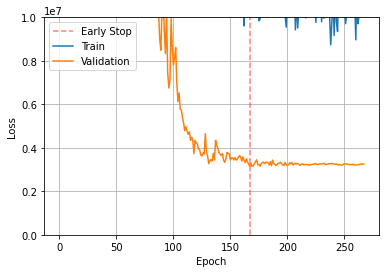

In [68]:
plot_loss(history)

In [ ]:
35.4420214621576  38.5987428412494  26.236052   -22.70123    5849.609    8681.0    7110.9146   1570.08544921875

In [16]:
test_labels

array([[3.54420215e+01, 3.85987428e+01, 8.68100000e+03],
       [2.38355169e+01, 5.26173648e+01, 1.56090000e+04],
       [3.90856075e+01, 3.72834854e+01, 2.41230000e+04]])

In [15]:
prediction

array([[   26.236052,   -22.70123 ,  7110.9146  ],
       [   58.843014,   -55.443256, 17105.238   ],
       [   68.426834,   -65.065765, 20041.902   ]], dtype=float32)

In [14]:
prediction = model.predict(test_features)
print(np.array(tf_haversine(prediction[:, 0:2], test_labels[:, 0:2].astype('float32'))))
print(prediction[:, 2]-test_labels[:, 2])

[5849.609  8730.545  6484.1304]
[-1570.08544922  1496.23828125 -4081.09765625]


2022-08-17 00:29:32.583866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
[ 181.47209  709.8934  1702.7517 ]
[ 176.71484375 1108.6875     1522.79882812]

In [ ]:
[ 993.2587 1608.6003 6772.9297]
[  54.50390625 1286.7890625  1260.31640625]

In [ ]:
[ 409.86987 1344.4915  3200.2073 ]
[ 318.95703125 1197.90234375 1753.21484375]

In [83]:
a = np.arange(4*8).reshape(4, 8)
n = tf.keras.layers.Normalization(input_shape=[a[1], ], axis = None, mean=0, variance=1)
n(a)

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.],
       [16., 17., 18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29., 30., 31.]], dtype=float32)>

In [84]:
n(np.arange(4*8).reshape(4, 8)*20)

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[  0.,  20.,  40.,  60.,  80., 100., 120., 140.],
       [160., 180., 200., 220., 240., 260., 280., 300.],
       [320., 340., 360., 380., 400., 420., 440., 460.],
       [480., 500., 520., 540., 560., 580., 600., 620.]], dtype=float32)>

In [194]:
earlystop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                           min_delta=0,
                                           patience=100,
                                           verbose=1)
    
reducelr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.5,
                                              patience=20)


def build_and_compile_model(norm = None, input_shape = None):
    
    
    model = keras.Sequential()
    if isinstance(norm, keras.layers.Normalization):
        print("Normalizing")
        model.add(norm)
        for _ in range(5):
            model.add(layers.Dense(256))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation('elu'))
    else:
        print("Not normalizing")
        model.add(layers.Dense(256, input_shape = input_shape))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('elu'))
        for _ in range(5):
            model.add(layers.Dense(256))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation('elu'))

    model.add(layers.Dropout(0.25))
    for _ in range(5):
        model.add(layers.Dense(256))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('elu'))
    model.add(layers.Dense(3))
    model.add(layers.Dense(3))

    model.compile(loss=euclidean_distance_loss,
    #model.compile(loss=haversine_distance_time_difference(w_time = 1, w_space = 1000),
    #model.compile(loss="mean_squared_error",
                  optimizer="Adam")
    return model

spaceNNtime_features_normalizer = tf.keras.layers.Normalization(input_shape=[train_features.shape[1], ], axis= -1)
spaceNNtime_features_normalizer.adapt(train_features)
#spaceNNtime_model = build_and_compile_model(norm = spaceNNtime_features_normalizer)
spaceNNtime_model = build_and_compile_model(input_shape = [train_features.shape[1], ])

spaceNNtime_labels_normalizer = tf.keras.layers.Normalization(input_shape=[train_labels.shape[1], ], axis= -1)
spaceNNtime_labels_normalizer.adapt(train_labels)

print(spaceNNtime_model.summary())

history = spaceNNtime_model.fit(train_features,
                                train_labels, 
                                #spaceNNtime_labels_normalizer(train_labels), 
                                epochs=5000,
                                batch_size=32,
                                shuffle=True,
                                verbose = 0,
                                validation_data=(val_features, 
                                                 val_labels),
                                                 #spaceNNtime_labels_normalizer(val_labels)),
                                callbacks=[earlystop,reducelr])

Not normalizing
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_182 (Dense)            (None, 256)               344320    
_________________________________________________________________
batch_normalization_143 (Bat (None, 256)               1024      
_________________________________________________________________
activation_154 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 256)               65792     
_________________________________________________________________
batch_normalization_144 (Bat (None, 256)               1024      
_________________________________________________________________
activation_155 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 2

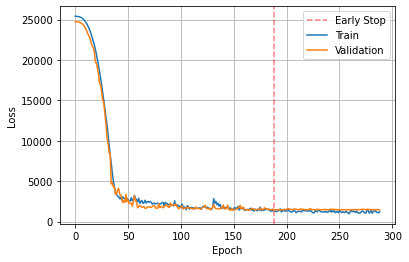

In [54]:
def plot_history(history, fig_path = None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    if fig_path:
        fig  = plt.figure()
    plt.axvline(x = int(hist[np.min(hist["val_loss"]) == hist["val_loss"]]["epoch"]), c = "red", alpha = 0.5, linestyle = "dashed", label='Early Stop')
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if fig_path:
        fig.savefig(fig_path)
        plt.close()
        
plot_history(history)

In [196]:
hist

,loss,val_loss,lr,epoch
0,25407.601562,24750.490234,0.001000,0
1,25400.187500,24731.677734,0.001000,1
2,25387.496094,24696.222656,0.001000,2
3,25365.390625,24651.701172,0.001000,3
4,25329.380859,24640.062500,0.001000,4
...,...,...,...,...
227,1436.837280,1521.820679,0.000031,227
228,1588.319458,1533.477783,0.000031,228
229,1321.667603,1526.908325,0.000031,229
230,1307.883301,1533.743530,0.000031,230


In [55]:
prediction = spaceNNtime_model.predict(test_features)
print(np.array(tf_haversine(prediction[:, 0:2], test_labels[:, 0:2].astype('float32'))))
print(prediction[:, 2]-test_labels[:, 2])

NameError: name 'spaceNNtime_model' is not defined

In [ ]:
GT euclidian distance

GT
new 1, 1000 =
[ 814.9021 2528.839  1750.46  ]
[  85.2734375  1182.8125     2249.20703125]

new 1000, 1 =
[ 163.09805  217.54398 1790.7006 ]
[ 222.9609375   328.93359375 1334.796875  ]

new 1000, 1 =
[  51.779472 1491.3511    972.02246 ]
[ 693.53515625  539.7109375  1265.32226562]
new 10, 1 =
[ 907.4219 1826.0155 1854.3685]
[ 1520.70703125 -2898.69140625   676.70117188]

mse no norm output
[ 703.4174 1463.9999 1967.8995]
[ 187.28125    1682.71484375 1173.8203125 ]

mse norm output
[7247.1284 6550.786  6999.171 ]
[-38131.0378055  -43541.83270764 -22740.13557646]

GP

new 1000, 1 =
[ 264.7253   385.80154 1055.6896 ]
[  845.42578125 -2143.0703125    -32.51757812]
new 10, 1 =
[ 907.4219 1826.0155 1854.3685]
[ 1520.70703125 -2898.69140625   676.70117188]
new2 1, 1 =
[ 774.4237 1557.5063 2035.4567]
[ 1136.1953125  -4329.2421875   -931.08007812]
new 1, 1 =
[1074.4224 1675.3339 1879.1251]
[ 2667.69921875 -4243.4453125   1560.72070312]
old = 
[ 397.28763  473.0714  1203.0016 ]
[  147.5546875  -2406.36328125   211.90429688]

In [247]:
earlystop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                           min_delta=0,
                                           patience=100,
                                           verbose=1)
    
reducelr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.5,
                                              patience=20)



def build_and_compile_model(norm, ):
    from tensorflow.keras import backend as K
    

    
    model = keras.Sequential()
    model.add(norm)
    [model.add(layers.Dense(256, activation='elu')) for _ in range(5)]
    model.add(layers.Dropout(0.25))
    [model.add(layers.Dense(256, activation='elu')) for _ in range(5)]
    model.add(layers.Dense(3))
    model.add(layers.Dense(3))

    model.compile(loss=euclidean_distance_loss,#'mean_squared_error',
                  optimizer="Adam")
    return model

spaceNNtime_features_normalizer = tf.keras.layers.Normalization(input_shape=[train_features.shape[1], ], axis= -1)
spaceNNtime_features_normalizer.adapt(train_features)
spaceNNtime_model = build_and_compile_model(spaceNNtime_features_normalizer)

spaceNNtime_labels_normalizer = tf.keras.layers.Normalization(input_shape=[train_labels.shape[1], ], axis= -1)
spaceNNtime_labels_normalizer.adapt(train_labels)

print(spaceNNtime_model.summary())

history = spaceNNtime_model.fit(train_features,
                                spaceNNtime_labels_normalizer(train_labels), 
                                epochs=5000,
                                batch_size=32,
                                shuffle=True,
                                verbose = 0,
                                validation_data=(val_features, spaceNNtime_labels_normalizer(val_labels)),
                                callbacks=[earlystop,reducelr])

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_72 (Normalizat (None, 4032)              8065      
_________________________________________________________________
dense_508 (Dense)            (None, 256)               1032448   
_________________________________________________________________
dense_509 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_510 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_511 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_512 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)             

In [ ]:
build_and_compile_model("None", )
model.load_weights(checkpoint_path)

5


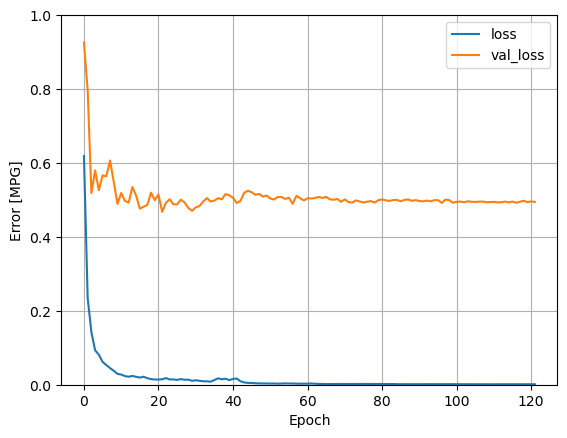

In [248]:
print("5")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [249]:
hist

,loss,val_loss,lr,epoch
0,0.618621,0.925896,0.001000,0
1,0.234329,0.796276,0.001000,1
2,0.141905,0.518569,0.001000,2
3,0.093176,0.580015,0.001000,3
4,0.081268,0.526278,0.001000,4
...,...,...,...,...
117,0.001334,0.494965,0.000063,117
118,0.001298,0.497714,0.000063,118
119,0.001305,0.493981,0.000063,119
120,0.001245,0.495980,0.000063,120


In [250]:
prediction = spaceNNtime_model.predict(test_features)
print(np.array(tf_haversine(prediction[:, 0:2], test_labels[:, 0:2].astype('float32'))))
print(prediction[:, 2]-test_labels[:, 2])

[7243.6772 6476.514  6945.7876]
[-38131.02693456 -43541.82767963 -22740.94043195]


In [ ]:
[ 277.2485   720.42334 1349.5867 ]
[ 2274.34375    -2021.2109375  -7282.44238281]

In [ ]:
[ 801.95746  914.8377  1101.7787 ]
[  7577.1953125   -9297.6640625  -22339.01763916]

In [ ]:
complicated - 0
[ 217.07812 1403.1825   578.2858 ]
[ 6724.0234375   1281.31054688 -1572.0078125 ]

In [ ]:
RuntimeError: Cannot enter into task Mean squared distance - 0
[7016.37   5275.3525 6382.9854]
[ -5469.25219095  -9251.22639191 -43805.61639833]